# Simulating Airnode behavior during Black Thursday
We look at how Airnode would have behaved during Black Thursday (March 12). Specifically, how much lag time would Airnode responses have had if we use the current gas price selection technique, which I'll call RAND1 for now. I did some more general analysis in the other notebook but this is meant to look at how RAND1 would behave in an outlier-like scenerio (e.g. Black Thursday).

### Assumptions
- Given an Ethereum block $B$, let the minimum gas price of any transaction in that block be $gasPrice_{min_B}$. We assume that *if* there had been a txn $x$ in the mempool (at roughly the time $B$ was mined) and that the gas cost of $x$ was *strictly greater* than $gasPrice_{min_B}$, then $x$ would have been included and mined in $B$.
    - Is this a good assumption? It's hard to say since the set of transactions mined in a given block is non deterministic, although definitely skewed toward the transactions with highest gas price. Truly evaluting the viability of this assumption would require a historical analysis of mem pool data, which is arguably impossible since the mem pool isn't actually recorded on the blockchain (mem pool txns are yet to be mined).
    
### Model setup
- We model Airnode operating continuously throughout the period between March 11 - March 14 (i.e. around the time of Black Thursday)
- Airnode is required to respond every minute.
- Airnode processes requests in parallel, so we can treat (i.e. model) responding to one request the same as responding to multiple.
- We model *success* as the Airnode's response being mined in $\le$ 1 minute.

In [1]:
# Imports
import datetime
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

In [2]:
API3_PURPLE = '#7963B2'
API3_EMERALD = '#7CE3CB'
# helper functions
to_date_str = lambda ts: datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

## Get historical transaction data

In [3]:
file_patterns = [
    'gas_prices_2020-03-11_2020-03-13_100%-sampling*',
]

fnames = []
for p in file_patterns:
    fnames.extend(glob.glob(p))
    
print(f"{len(fnames)} total files.")

# concat all data into one dataframe
l = []
for fname in fnames:
    df = pd.read_csv(fname, index_col=None, delimiter='\t')
    l.append(df)

df = pd.concat(l, axis=0, ignore_index=True)

# convert wei to gwei
df['gasPrice'] = df['gasPrice'] / 1_000_000_000

# remove last block num just in case (files are cut off)
df = df[df.blockNum != df.blockNum.max()]

# sort
df = df.sort_values(by=['blockNum'])
df

198 total files.


,blockNum,timeStamp,txnID,gasPrice
0,9646854,1583884773,0x1eb4d0a5e7702cf65d4a2e49743989cfc39a005d7d70...,40.0
29,9646854,1583884773,0x1906edf9ba5a06ad9870910892b4a34bc1d2fe3885ef...,10.0
28,9646854,1583884773,0xd9867d0d23048a0a7afa255c411597aac87dde6b7c58...,10.0
27,9646854,1583884773,0x0ce33d9fd0a59f3b9d8fe16c51c24bd5f1eea6b9f479...,10.0
26,9646854,1583884773,0x6e27c8fe7fa22d438e635e7085d0f971ee4e0438638d...,12.0
...,...,...,...,...
179205,9654854,1583990380,0xeedb7b86117d47b9c5f2f81c04685a07c5520a91a27a...,20.0
179204,9654854,1583990380,0xcdba4be4d4c04755720a69bf71c270c5130d7a408525...,20.0
179203,9654854,1583990380,0xf2bce74b5871917bc00ca50ff5fa9ed02479bae4d18e...,20.0
179201,9654854,1583990380,0x57562e508ff4d1887d3f2b89ea809e294e68bf038b0f...,20.0


In [4]:
start_ts = df.iloc[0]['timeStamp']
end_ts = df.iloc[-1]['timeStamp']

print("PRECISE DATE RANGE")
print(f"Start:\t{to_date_str(start_ts)}")
print(f"End:\t{to_date_str(end_ts)}")

PRECISE DATE RANGE
Start:	2020-03-10 23:59:33
End:	2020-03-12 05:19:40


# Visualizing historical gas prices

In [5]:
df2 = df # in order to preserve the same df throughout; i.e. not modified

In [6]:
# group per hour

to_hour = lambda ts: datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H')
df2['hour'] = df.timeStamp.apply(to_hour)
to_min = lambda ts: datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M')
df2['minute'] = df.timeStamp.apply(to_min)
df2['minute_10'] = df2['minute'].apply(lambda x: x[:-1])

# drop hour with little data (right before March 11)
df2 = df2[df2['hour'] != '2020-03-10 23']

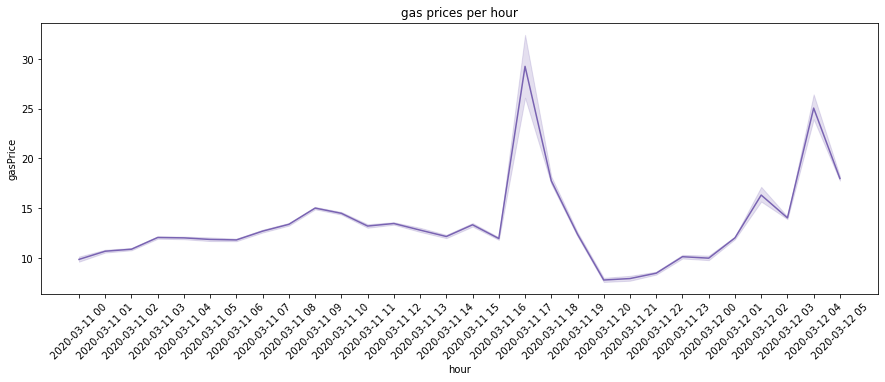

In [7]:
_, ax = plt.subplots(1, 1, figsize=(15,5))

g = sns.lineplot(data=df2, x='hour', y='gasPrice', color=API3_PURPLE)

plt.xticks(rotation=45)
g.set_title('gas prices per hour');

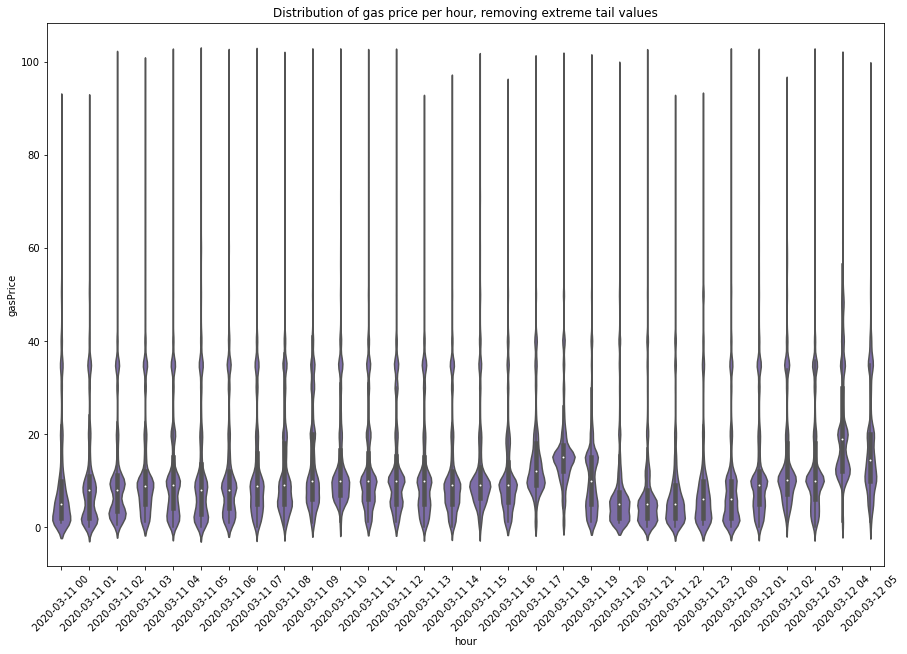

In [8]:
df3 = df2

_, ax = plt.subplots(1, 1, figsize=(15,10))

# NOTE:
# there are a couple of crazy outliers that make the distributions very difficult to read
df3 = df3[df3['gasPrice'] < 100]

g = sns.violinplot(
    ax=ax,
    x="hour",
    y="gasPrice",
    height=1,
    aspect=1,
    color=API3_PURPLE,
    data=df3
)

plt.xticks(rotation=45)
g.set_title("Distribution of gas price per hour, removing extreme tail values");

In [9]:
#grouped = df3.groupby('hour')['gasPrice']
#grouped.max(), grouped.idxmax()

# Modeling Airnode behaviour
1. Airnode wakes up every minute
    * We assume it always has requests, and thus must make a transaction every minute.  
2. It checks the most recently mined block.
3. It randomly selects a txn from that block.
    * We ignore, for now, how this is done programmatically.
4. The gas price of that txn is selected as the price of Airnode's current txn.
    * TODO: come up with some way to mitigate against selecting an extreme gas price (e.g. frontrunning txns)

In [10]:
# We randomly select when the Airnode starts running, within a minute of the first block from our historical data.
airnode_start_ts = df.iloc[0]['timeStamp'] + random.randint(0, 60)
print(f'Airnode start time: {to_date_str(airnode_start_ts)}')

Airnode start time: 2020-03-10 23:59:45


In [11]:
end_buffer = 120
airnode_wake_up_times = range(airnode_start_ts, end_ts - end_buffer, 60)

In [12]:
# store results
results = {
    'ts': [], # timestamp of Airnode 'wake up time'
    'gasPrice': [], # gas prices of response txns
    'mined?': [], # whether or not the txn was mined within the minute
}

# queue of block numbers
block_queue = list(df['blockNum'].unique())
block_queue.sort() # just in case

# dataframe containing only min gas price per block
df_min = df.groupby('blockNum').min()[['gasPrice', 'timeStamp']]

### 1. Airnode wakes up
for i,ts in enumerate(airnode_wake_up_times):

    ### 2. Checks most recently mined block
    prev = block_queue.pop(0)
    curr = block_queue.pop(0)
    
    # ensure: current_block.ts <= ts < next_block.ts
    while df_min.loc[curr].timeStamp <= ts:
        prev = curr
        curr = block_queue.pop(0)
        
    current_block = prev
    next_block = curr
    
    assert df_min.loc[next_block].timeStamp <= ts < df_min.loc[next_block].timeStamp
    
    ### 3. Randomly selects a txn from block
    gas_prices = df[df['blockNum'] == current_block]['gasPrice'].values
    
    ### 4. The gas price of that txn is selected by Airnode.
    chosen_gas_price = random.choice(gas_prices)
    # NOTE: assume we have some way of removing extreme values
    while chosen_gas_price > np.mean(gas_prices) + 2 * np.std(gas_prices):
        chosen_gas_price = random.choice(gas_prices)
    
    ### EVALUATE: 
    # Is this gas price *strictly greater* than the min gas price
    # in all blocks mined in the next minute??
    
    # get all blocks mined within the minute
    # NOTE: don't pop!
    nxt_blocks = [next_block]
    j = 0
    while df_min.loc[block_queue[j]].timeStamp <= ts + 60:
        nxt_blocks.append(block_queue[j])
        j += 1
        
    min_ = min(df_min.loc[b]['gasPrice'] for b in nxt_blocks)
    
    # update results
    results['ts'].append(ts)
    results['gasPrice'].append(chosen_gas_price)
    
    if chosen_gas_price > min_:
        results['mined?'].append(True)
    else:
        results['mined?'].append(False)
        
df_results = pd.DataFrame(results)
df_results

,ts,gasPrice,mined?
0,1583884785,15.000000,True
1,1583884845,7.000001,True
2,1583884905,5.000000,True
3,1583884965,1.034610,True
4,1583885025,7.000001,True
...,...,...,...
1753,1583989965,13.500000,True
1754,1583990025,40.000000,True
1755,1583990085,9.000000,True
1756,1583990145,12.000000,True


In [21]:
df_results.mean()[['gasPrice', 'mined?']]

gasPrice    12.294131
mined?       0.914676
dtype: float64

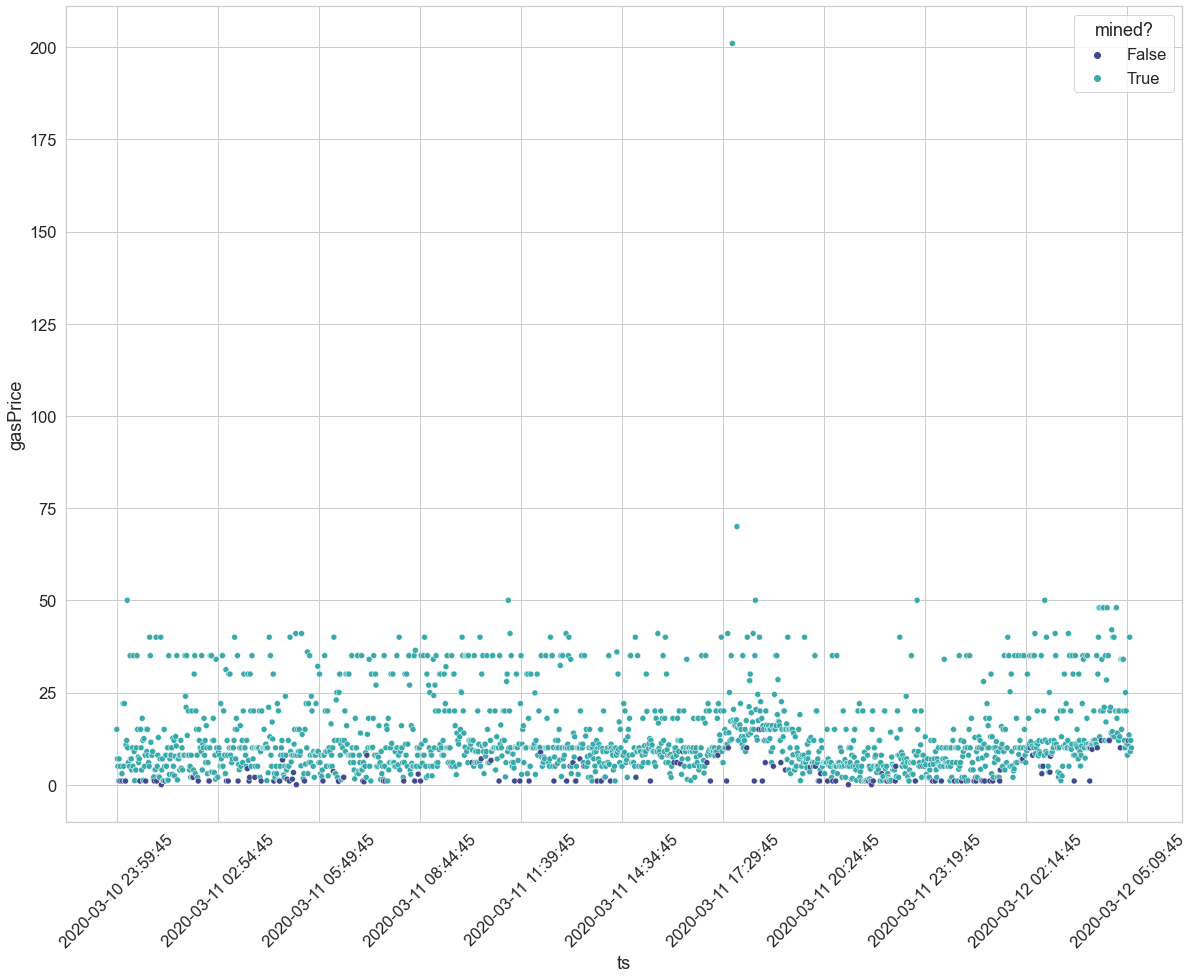

In [14]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

_, ax = plt.subplots(1, 1, figsize=(20,15))

sns.scatterplot(data=df_results, x="ts", y="gasPrice", hue="mined?", palette="mako", sizes=(20, 200))

n = len(df_results['ts'])
ticks = [df_results['ts'][i] for i in range(0, n, n // 10)]
plt.xticks(ticks, [to_date_str(x) for x in ticks]);
plt.xticks(rotation=45);

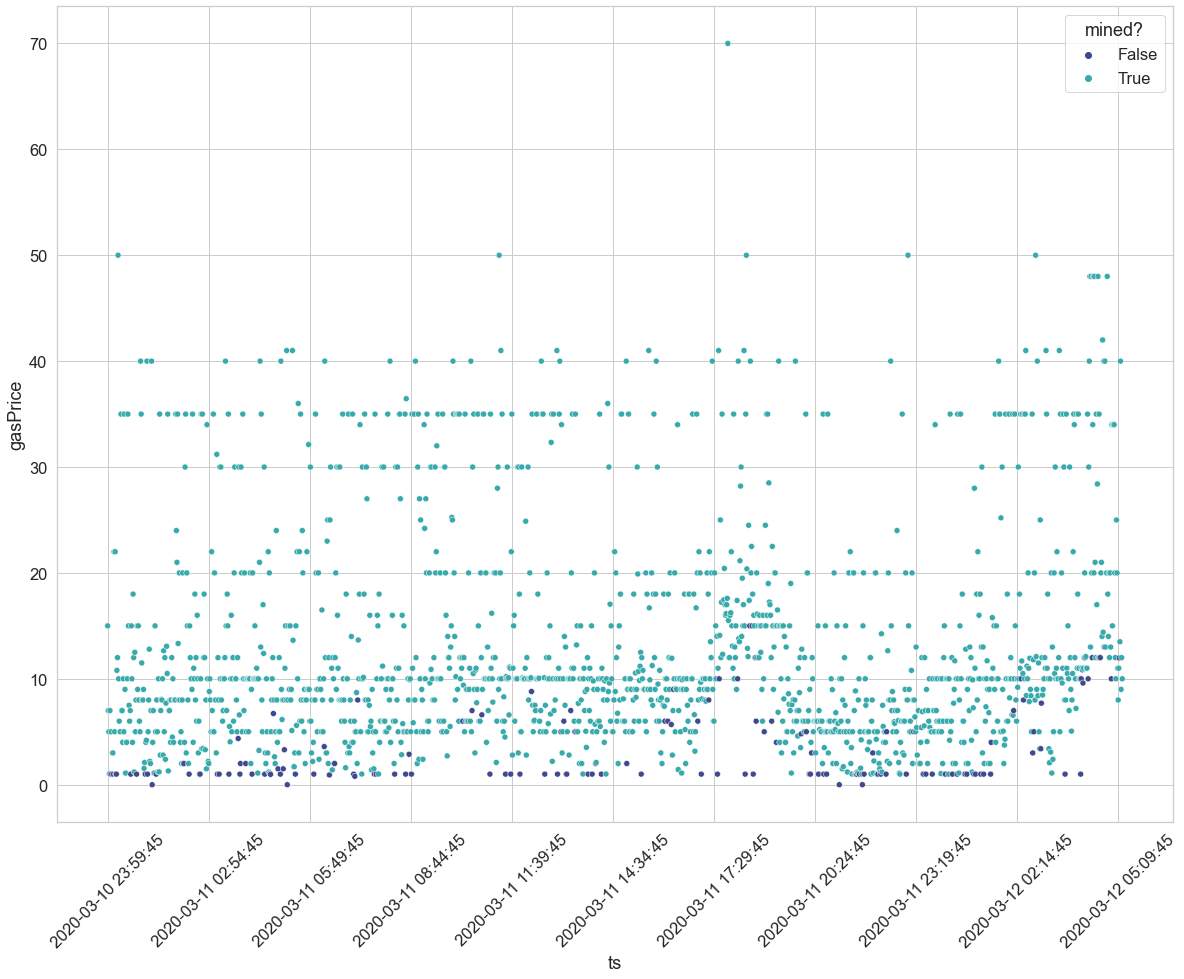

In [15]:
# "zoom in", ignore extreme values
df4 = df_results[df_results['gasPrice'] < 200]

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

_, ax = plt.subplots(1, 1, figsize=(20,15))

sns.scatterplot(data=df4, x="ts", y="gasPrice", hue="mined?", palette="mako", sizes=(20, 200))

n = len(df4['ts'])
ticks = [df4['ts'][i] for i in range(0, n, n // 10)]
plt.xticks(ticks, [to_date_str(x) for x in ticks]);
plt.xticks(rotation=45);

### What's the longest lag time? I.e. what's the maximum # of minutes we wait to get mined?

In [16]:
df_results

,ts,gasPrice,mined?
0,1583884785,15.000000,True
1,1583884845,7.000001,True
2,1583884905,5.000000,True
3,1583884965,1.034610,True
4,1583885025,7.000001,True
...,...,...,...
1753,1583989965,13.500000,True
1754,1583990025,40.000000,True
1755,1583990085,9.000000,True
1756,1583990145,12.000000,True


In [17]:
df_results.mean()[['gasPrice', 'mined?']]

gasPrice    12.294131
mined?       0.914676
dtype: float64

In [18]:
blocks = (df_results != df_results.shift()).cumsum()
block_ranges = blocks.groupby('mined?', group_keys=False).apply(lambda x: (x.index[0], x.index[-1]))

df5 = pd.DataFrame(block_ranges, columns=["range"]).reset_index().drop(columns=['mined?'])
df5['mined?'] = df5["range"].apply(lambda x: df_results.loc[x[0]]['mined?'])
df5['length'] = df5["range"].apply(lambda x: x[1] - x[0] + 1)

df5

,range,mined?,length
0,"(0, 4)",True,5
1,"(5, 5)",False,1
2,"(6, 6)",True,1
3,"(7, 7)",False,1
4,"(8, 9)",True,2
...,...,...,...
270,"(1727, 1737)",True,11
271,"(1738, 1738)",False,1
272,"(1739, 1751)",True,13
273,"(1752, 1752)",False,1


In [19]:
df5.groupby('mined?').mean()

,length
mined?,
False,1.094891
True,11.652174


In [22]:
df6 = df5[df5['mined?'] == False]
df6.groupby('length').count()

,range,mined?
length,,
1,124,124
2,13,13


### TODO

- overpaying? what about: sample 2 and take the min. Does the cost of potentially picking large gas prices outweigh the benefit of saving on API calls and responding quickly?
- how to prevent extreme values being chosen
- TODO: run sim under different initialization values